In [1]:
import pandas as pd 
import numpy as np

In [2]:
raw_sessiondata = pd.read_csv("20210309-125518.csv", skiprows=6, delimiter = ';')

In [3]:
#Add a column for 'timestamps'
import time
import datetime
import ciso8601

timestamp = []
for i in range(len(raw_sessiondata.index)):
    t = raw_sessiondata['PC-TIME'].iloc[i]
    ts= ciso8601.parse_datetime(t)
    if i == 0:
        t0= time.mktime(ts.timetuple())+ts.microsecond/1000000
        timestamp.append(np.around(t0-t0,3))
    else:
        tnow = time.mktime(ts.timetuple())+ts.microsecond/1000000
        timestamp.append(np.around(tnow-t0,3))

raw_sessiondata['timestamps'] = timestamp

In [4]:
df_group_msg = raw_sessiondata.groupby('MSG')
df_group_info = raw_sessiondata.groupby('+INFO')
df_group_type = raw_sessiondata.groupby('TYPE')

In [5]:
#get open valve time to see how many times the valve has opened: i.e. when the animal actually licked in response to tone
df_openvalve = df_group_msg.get_group('open_valve')
timestamps_reward = df_openvalve.timestamps.to_numpy()
len(timestamps_reward)

87

# X Matrix

#### Get Reward Timestamp

In [6]:
# Get reward onsets 
df_lick_waiting = df_group_msg.get_group('lick_waiting')
timestamps_lick_waiting = df_lick_waiting.timestamps.to_numpy()

# Get Reward ON timestamp
evenindex = np.arange(0, len(timestamps_lick_waiting) + 2, 2)
rewardON = np.take(timestamps_lick_waiting, evenindex[:-1])

In [7]:
# Get Reward OFF timestamp
df_retract_spout = df_group_msg.get_group('retract_spout')
timestamps_retract_spout = df_retract_spout.timestamps.to_numpy()
rewardOFF = np.take(timestamps_retract_spout, evenindex[:-1])

##### Note: Reward has delivered 44 times (i.e. odd number of 'open_valve') (i.e. animal has licked), but reward is delivered in 48 sessions, so the animals has missed 4 lick sessions!!!

### Number of licks for each Reward

In [8]:
# Get Lick timestamps
df_port1out = df_group_info.get_group('Port1Out')
df_port1out = df_port1out.timestamps.to_numpy()

df_port2out = df_group_info.get_group('Port2Out')
df_port2out = df_port2out.timestamps.to_numpy()

df_port3out = df_group_info.get_group('Port3Out')
df_port3out = df_port3out.timestamps.to_numpy()

df_port4out = df_group_info.get_group('Port4Out')
df_port4out = df_port4out.timestamps.to_numpy()

In [9]:
#Aggregate all licking according to time
allport = np.hstack((df_port1out,df_port2out, df_port3out,df_port4out))
sorted_allport = np.sort(allport)

## Sort lick behavior according to each trial

In [10]:
lickpertrial = [[] for _ in range(48)]

for i in range(48):
    a = sorted_allport[(rewardON[i] < sorted_allport) & (sorted_allport< rewardOFF[i])]
    lickpertrial[i].append(a)

numoflickspertrial = np.zeros(48)
for i in range(48):
    numoflickspertrial[i] = len(lickpertrial[i][0])

b = [i for i in range(48)]

Text(0, 0.5, 'Number of Licks per Trial')

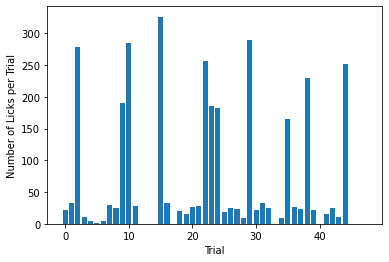

In [11]:
import matplotlib.pyplot as plt
plt.bar(b, numoflickspertrial)
plt.xlabel('Trial')
plt.ylabel('Number of Licks per Trial')

### X1 (Feature 1): Run speed before each Reward

Here, I am getting run speed 5s before reward delivery, totally arbituary

In [12]:
df_run = pd.read_hdf('session.running_speed1ms.h5')

In [13]:
prereward = []
for i in range(len(rewardON)):
    a = df_run[(rewardON[0] - 5 <df_run['timestamps']) & (df_run['timestamps']<rewardON[0])]['speed1ms']
    prereward.append(a)

speed_prereward = np.array(prereward)

In [14]:
np.shape(speed_prereward)

(48, 4999)

### X2 (Feature 2): Latency to Lick after tone is played

In [15]:
# Find Audio timestamps ('BNC1High'), process so no duplicates
df_audio = df_group_msg.get_group('trial_start')
a = df_audio['timestamps'].diff().fillna(df_audio['timestamps']) > 10
timestamps_audio = df_audio.loc[a].timestamps.to_numpy()

In [16]:
f_lick = []
for i in range(48):
    b = sorted_allport[(timestamps_audio[i] < sorted_allport)]
    f_lick.append(b)

first_lick = []
for i in range(46):
    first_lick.append(f_lick[i][0])

In [17]:
first_lick_arr = np.array(first_lick + [0,0])

In [18]:
latency_to_lick = first_lick_arr - timestamps_audio
latency_to_lick[-1] = 0
latency_to_lick[-2] = 0

In [19]:
#plt.bar(b, latency_to_lick)


### X3 (Feature 3): chunk of time in session (1,2,3,4)

In [20]:
time_in_trial = np.array([0,0,0,0,0,0,0,0,0,0,0,0,
                         1,1,1,1,1,1,1,1,1,1,1,1,
                        2,2,2,2,2,2,2,2,2,2,2,2,
                        3,3,3,3,3,3,3,3,3,3,3,3])

In [21]:
np.shape(time_in_trial )

(48,)

### X4 (Facial Features): frames 5 seconds before each reward (first 2 components from each of the 2 rois respectively)

In [22]:
facialdata = np.load('Hippo3_3P_session2_proc.npy',allow_pickle=True).item()

In [23]:
#facialdata

In [24]:
facialSVD = facialdata['motSVD'] #3 = motion mask; 500 = components
np.shape(facialSVD)

(3, 40182, 500)

In [25]:
roione = facialSVD[1]
roitwo = facialSVD[2]

In [26]:
firstcomponent_roione = roione[:,0] #33fps 
twocomponent_roione = roione[:,1]

firstcomponent_roitwo = roitwo[:,0] #33fps 
twocomponent_roitwo = roitwo[:,1]

In [27]:
preward_firstcomponent_roione = []
preward_twocomponent_roione = []

preward_firstcomponent_roitwo = []
preward_twocomponent_roitwo = []

for i in range(len(rewardON)):
    begin = int(np.round(rewardON[i])*33)
    one_save = firstcomponent_roione[begin-33*5:begin]
    preward_firstcomponent_roione.append(one_save)
    
    two_save = twocomponent_roione[begin-33*5:begin]
    preward_twocomponent_roione.append(two_save)
    
    two_one_save = firstcomponent_roitwo[begin-33*5:begin]
    preward_firstcomponent_roitwo.append(two_one_save)
    
    two_two_save = twocomponent_roitwo[begin-33*5:begin]
    preward_twocomponent_roitwo.append(two_two_save)

In [28]:
preward_firstcomponent_roione = np.array(preward_firstcomponent_roione)
preward_twocomponent_roione = np.array(preward_twocomponent_roione)

preward_firstcomponent_roitwo = np.array(preward_firstcomponent_roitwo)
preward_twocomponent_roitwo = np.array(preward_twocomponent_roitwo)

## Creating actual X-matrix

In [177]:
X_matrix = np.column_stack((speed_prereward, time_in_trial, latency_to_lick,
                            preward_firstcomponent_roione,preward_twocomponent_roione,
                           preward_firstcomponent_roitwo,preward_twocomponent_roitwo))  #need to figure out shape

# Y Vector - Predicted Trial

In [178]:
sessionparams = pd.read_csv("session_params.csv", header = None, delimiter = ',')
trialtype = np.array(sessionparams.iloc[2])
y_trialtype = trialtype[1:-1]

In [179]:
np.shape(y_trialtype)   #This coincide with 'retract_spout': also 48!

(48,)

## Split Data

In [186]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_matrix, y_trialtype, test_size=0.5, random_state=10)

## Classifier

In [195]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(loss="hinge", penalty="l2").fit(X_train, y_train)

In [196]:
predictlick = model.predict(X_test)
predictlick

array([3., 1., 1., 4., 2., 1., 4., 4., 3., 4., 2., 1., 3., 1., 3., 1., 4.,
       2., 1., 2., 4., 2., 3., 4.])

In [197]:
y_test

array([3., 3., 1., 4., 2., 1., 4., 4., 1., 4., 2., 3., 3., 1., 3., 1., 4.,
       2., 1., 2., 2., 2., 1., 4.])

Text(0, 0.5, 'Trial Type')

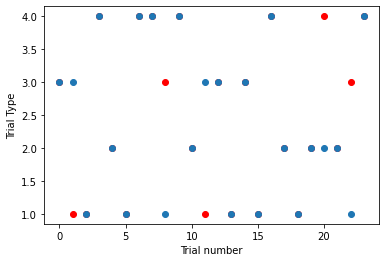

In [221]:
plt.scatter(np.arange(24),predictlick, color = 'red')
plt.scatter(np.arange(24),y_test)
plt.xlabel('Trial number')
plt.ylabel('Trial Type')

In [180]:
from sklearn.linear_model import LinearRegression

In [181]:

#fit model to training data
model = LinearRegression().fit(X_train, y_train)
predictlick = model.predict(X_test)
predictlick

array([1.95310781, 2.10920145, 2.2818534 , 2.542288  , 2.76271332,
       2.6788063 , 2.95340732, 3.18556679, 1.77776553, 3.3950048 ,
       3.55431759, 2.43885733, 1.79969524, 2.11454271, 2.67757862,
       2.75605115, 1.3520003 , 2.72666239, 2.59489924, 3.06464976,
       2.61865261, 2.71819772, 2.89381406, 3.85524797])

In [182]:
y_test

array([3., 3., 1., 4., 2., 1., 4., 4., 1., 4., 2., 3., 3., 1., 3., 1., 4.,
       2., 1., 2., 2., 2., 1., 4.])

In [156]:
#Latency to add stuff

In [157]:
#predicting lick pattern for each reward type


    
COMPAREEEEEE 
Reward Lick Rate 
1. reward type: could have high predictive value for lick rate 
2. another feature: time where in the trial u are: dividde trials in e.g.  4 different chunks  (e.g. satiety)
        (right now im just using a random value to chunk, but i'd want to use video data/facial data to find out whether
        there is a some state that u can find out that may be correlated with hunger state.)
 



we think that lick pattern is influence by different stuff. and i wanted to find out whether it is true?? 
-> build model -> try to reward lick type! 

right 
            

SyntaxError: invalid syntax (<ipython-input-157-dfed295631bb>, line 6)